農研機構メッシュ農業気象データシステム(AMGSDS) 　ドキュメント<br>
チュートリアル　５ CSVファイルの読み書き

# CSVファイルの読み書き
　このチュートリアルでは、メッシュ農業気象データやその処理結果を CSV ファイルに書き出す方法と、CSVファイルにまとめられたデータをプログラムに読み込む方法を学習します。

　まず、以下のセルを実行し、このチュートリアルで使用するライブラリを読み込んでください。
（実行後は、左端の青太線をクリックして畳んでおいてください）

In [ ]:
# このチュートリアルで使用するライブラリ
import numpy as np
import pandas as pd
import AMD_Tools3 as amd

## 1 ３次メッシュコードを見出しとするデータの書き出し
　メッシュデータの配列を表として表現する方法の一つとして、配列要素値を以下のような１行の文字列にして、メッシュの数だけ縦に並べる方法があります。
 
 　　　 _３次メッシュコード_ , _データ_

　この方法は、メッシュの数だけ行が作られ冗長に見えることもありますが、２次元配列にも３次元配列にも対応でき、GIS とも相性が良い方法です。このような　CSV ファイルは、ライブラリ AMD_Tools3 が提供する関数 **PutCSV_MT** がで作ることができます。

```python
AMD_Tools3.PutCSV_MT(data, lat, lon, addlalo=False, header=None, filename='result.csv', removenan=True, delimiter=',')
```
引数(必須)：<br>
* **data**： 出力しようとする2次元(緯度,経度)、または３次元(緯度,経度,任意)の配列
* **lat**： 出力しようとする配列の緯度座標の配列
* **lon**： 出力しようとする配列の経度座標の配列
  
引数(必要なときだけ使用)：<br>
* **addlalo**: 基準3次メッシュコードに加え、当該メッシュの緯度経度値も書き出したい場合にTrueを指定する。省略した場合は出力されない。
* **header**: テーブルの上に見出しを追加したいときにその文字列を指定する。指定した文字列が先頭行として追加される。
* **filename**: 出力されるファイル名を指定するときに使用する。省略した場合は「result.csv」となる。
* **removenan**: 海上など、当該要素の値が無効値であっても、その基準３次メッシュコードの書き出しをするときにFalseを指定する。省略した場合は無効値だけの3次メッシュは書き出さない。
* **delimiter**: データ間の区切り文字を、カンマ「','」以外に設定したいときに使用する。

戻り値：なし

　使用する際には、ライブラリ **AMD_Tools3** を事前にインポートしておきます。

#### 例１
　高知県の室戸岬先端周辺の、下図に示す 30 メッシュの領域の、2023年6月1日の日平均気温データ(２次元)を、この形式で CSV ファイルとして書き出す。

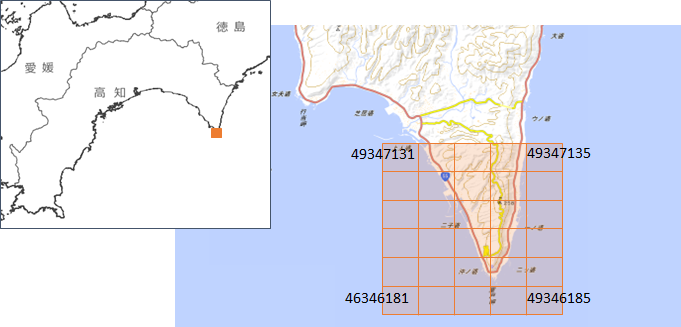

　まず、気象データを取得しましょう。

In [ ]:
# 変数に取得条件を設定
nani = 'TMP_mea'                         #気象要素の指定。TMP_meaは日平均気温を意味します。
itsu = ['2016-06-01', '2016-06-01']         #期間の設定。
doko = [33.2375, 33.2792, 134.1437, 134.1938]    #領域の設定。室戸岬の先端あたりです。

# 設定に基づき気象データを取得
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko)
print(data)

　それでは、関数 **.PutCSV_MT** を使ってこれを CSV ファイルにします。

In [ ]:
# CSVファイルへの書き出し
amd.PutCSV_MT(data, lat, lon, filename='Ta_Muroto1.csv')

　作られたファイルを表計算ソフト等で開き、内容が以下のようになっていることを確認してください。
 
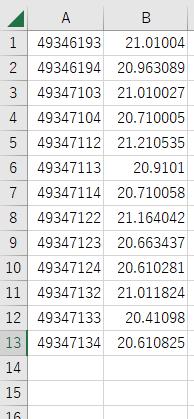

　関数 PutCSV_MT は、デフォルトでは値が無効値の要素については行を書き出しません。今回、取得したデータは、総数は30メッシュですが、データが存在するのはそのうち13メッシュなので、書き出されるのも13行だけとなっています。全ての要素を書き出したい場合は、引数に「 **removenan=False** 」を追加してください。

#### 例２
　高知県の室戸岬先端周辺の、下図に示す 30 メッシュの領域の、2023年6月1日～6月3日の日平均気温データ(３次元)を、3次メッシュコードをキーとする CSV ファイルとして書き出す。<br>
　その際、各メッシュの中心緯度と中心経度も出力に加えるとともに、最初の行に見出しを追加する。

In [ ]:
# 変数に取得条件を設定
nani = 'TMP_mea'                         #気象要素の指定。TMP_meaは日平均気温を意味します。
itsu = ['2016-06-01', '2016-06-03']         #期間の設定。
doko = [33.2375, 33.2792, 134.1437, 134.1938]    #領域の設定。室戸岬の先端あたりです。

# 設定に基づき気象データを取得
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko)

In [ ]:
# 列見出しの作成
dates = [d.strftime('%Y-%m-%d') for d in tim]
header = 'MeshCode, latitude, longitude, ' + ', '.join(dates)

# CSVファイルへの書き出し
amd.PutCSV_MT(data, lat, lon, addlalo=True, header=header, filename='Ta_Muroto2.csv')

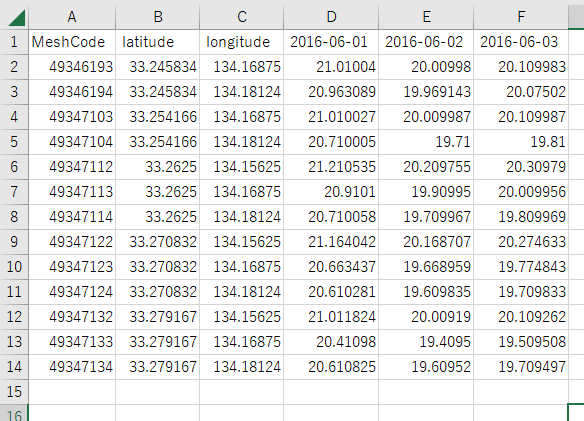

## 2 特定メッシュにおける時系列データの書き出し
　特定のメッシュにおけるデータの時系列を CSV ファイルに書き出すときには、特定の時刻(日付)のデータを以下のような１行の文字列にして、日付の数だけ縦に並べる方法が一般的に用いられます。

　　　 _日付_ , _データ_

　このような CSV ファイルは、Pythonのライブラリ **pandas** の力を借りると効率的に作成できます。

　ライブラリ **pandas** は、表形式のデータを取り扱うための大変ポピュラーなライブラリで、 **DataFrame** と呼ばれる便利なオブジェクトを提供します。これを使い、以下の流れでファイルを作ります。
 
メッシュデータの配列　→　DataFrameオブジェクト　→　CSVファイル
 
 以下に **pandas** のサイトのチュートリアル文書の導入部分のURLを付すので、参照してください。

https://pandas.pydata.org/docs/getting_started/intro_tutorials/01_table_oriented.html#min-tut-01-tableoriented

#### 例
　愛知県名古屋市内(名古屋地方気象台)における2023年6月1日～10日の日平均気温、日平均湿度、日積算降水量をCSVファイルに出力する。

　まず気象データを取得し、1次元配列に整形します。

In [ ]:
# 変数に取得条件を設定
nani = ['TMP_mea', 'RH', 'APCP']
itsu = [ "2023-06-01", "2023-06-10" ]
doko = [ 35.1666, 35.1666, 136.965, 136.965 ]

# 設定に基づき気象データを取得
data, tim, lat, lon = amd.GetMetData(nani[0], itsu, doko)
Ta = data[:,0,0]
data, tim, lat, lon = amd.GetMetData(nani[1], itsu, doko)
RH = data[:,0,0]
data, tim, lat, lon = amd.GetMetData(nani[2], itsu, doko)
Pr = data[:,0,0]

print(Ta)
print(RH)
print(Pr)

　次に、これらの配列を結合したうえで、日付情報も加えて DataFrame オブジェクトに纏めます。

In [ ]:
# データを pandas.DataFrameオブジェクトにまとめる
df = pd.DataFrame(np.array([Ta,RH,Pr]).T, dtype=np.float32,
                  columns = nani,
                  index = tim,
                  )
df

　最後に、これを CSV ファイルとして書き出します。

In [ ]:
# CSVファイルへの書き出し
df.to_csv('Met_Nagoya.csv')

　この例では、時系列データの出力として、オブジェクト DataFrame とそのメソッドである **to_csv** を紹介しましたが、すでにお気づきの通り、DataFrame に纏めてありさえすればどのようなデータも CSV ファイルとして出力できます。

## 3 CSVファイルの読み込み
　CSVファイルの読み込みも、ライブラリ **pandas** で簡単に行えます。

#### 例
　水稲栽培試験の栽培条件の一覧をまとめたファイル「 **CSVファイルの読み書き_読み込みサンプル.csv** 」(下図)を読み込んで、DataFrameオブジェクトを生成する。

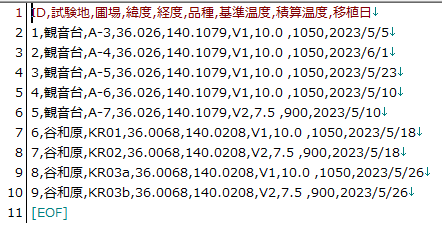

In [ ]:
# 読み込み
xp = pd.read_csv("5_CSVファイルの読み書き_読み込みサンプル.csv",       # ファイル名
                 encoding="Shift_JIS",    # 文字コード（Excelやネットから取得したものはほぼシフトJIS）
                 parse_dates=["移植日"],  # 日付と理解できる文字列は日付と見なす
                )
xp

DataFrame オブジェクトに対しては、様々な操作が可能ですが、最も基礎的な、特定のデータの取り出しは、インデックス（最も左の列の値）と列名を用いて下のようにして行います。

In [ ]:
xp['移植日'][5]